In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
calls_df = pd.read_csv("../output/calls.csv", sep = ";", encoding = "utf8")
locations_df = pd.read_csv("../output/locations.csv", sep = ";", encoding = "utf8")
voyages_df = pd.read_csv("../output/voyages.csv", sep = ";", encoding = "utf8")
ships_df = pd.read_csv("../output/ships.csv", sep = ";", encoding = "utf8")

Merge calls and locations dataframes

In [3]:
call_locations_df = pd.merge(calls_df, locations_df,
                            how = "left",
                            left_on = "location",
                            right_on = "location_id")
call_locations_df.rename(columns = {"location_y": "location_name"}, inplace = True)

Merge voyage and calls dataframes

In [4]:
voyage_call_df = pd.merge(voyages_df, calls_df,
                            how = "left",
                            on = "voyage_id")

Calculate the number of voyages active per year

In [5]:
def active_voyage_creator(voyages_df):
    active_voyages_dict = {}
    # To filter out errors outside the timerange
    for year in range(1600, 1850):
        active_voyages_dict[year] = 0
    start_years = voyages_df["start"].tolist()
    end_years = voyages_df["end"].tolist()
    for start, end in zip(start_years, end_years):
        if str(start).isdigit() and str(end).isdigit():
            start = int(start)
            end = int(end)
            if start in range(1600, 1850) and end in range(1600, 1850):
                for year in range(start, end + 1):
                    active_voyages_dict[year] += 1  
    active_voyages_df = pd.DataFrame.from_dict(active_voyages_dict, orient = "index")
    active_voyages_df.rename(columns = {0: "count"}, inplace = True)
    active_voyages_df = active_voyages_df.reset_index().rename(columns = {"index": "year"})
    return active_voyages_df
active_voyages_df = active_voyage_creator(voyages_df)
active_voyages_df.head()

,year,count
0,1600,4
1,1601,6
2,1602,2
3,1603,4
4,1604,5


## Initial exploration

How many calls locations are there?

In [6]:
len(locations_df.loc[locations_df["category"] == "calls"].index)

1523

How many calls with identified locations are there?

In [7]:
len(call_locations_df.index)

32642

How many calls with identified and geocoded locations are there?

In [8]:
len(call_locations_df.loc[call_locations_df["lat"].notna()])

29690

Save calls with identified locations per region

In [9]:
for region in call_locations_df["region"].unique():
    call_locations_region_df = call_locations_df.loc[call_locations_df["region"] == region]
    call_locations_region_df.to_csv("calls/calls_" + str(region) + ".csv", sep = ";", encoding = "utf8")

## Over time

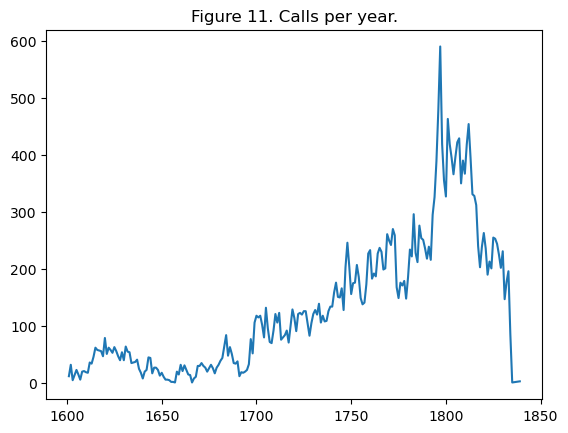

In [10]:
calls_per_year_df = pd.DataFrame(calls_df.value_counts("year"))
calls_per_year_df = calls_per_year_df.reset_index().rename(columns = {0: "count"})
calls_per_year_df = calls_per_year_df.sort_values(by = "year")
plt.plot(calls_per_year_df["year"], calls_per_year_df['count'])
plt.title('Figure 11. Calls per year.')
plt.savefig("calls/per_year.png",
            dpi = 300,
            facecolor = "white",
            bbox_inches = "tight")
plt.show()

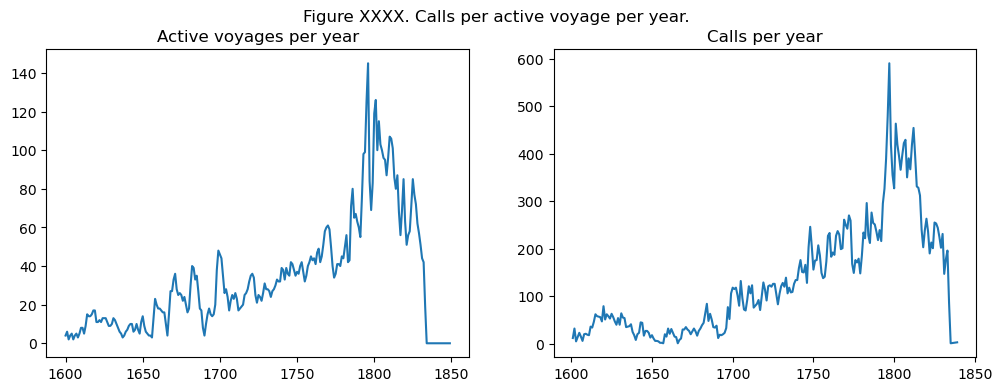

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(active_voyages_df["year"], active_voyages_df["count"])
axs[0].set_title("Active voyages per year")
axs[1].plot(calls_per_year_df["year"], calls_per_year_df["count"])
axs[1].set_title("Calls per year")
plt.suptitle("Figure XXXX. Calls per active voyage per year.")
plt.subplots_adjust(wspace=0.2)
plt.savefig("calls/voyages_vs_calls.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

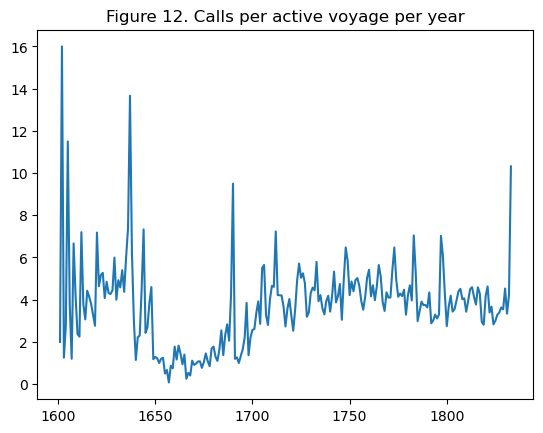

In [12]:
voyage_call_df = active_voyages_df.merge(calls_per_year_df, how = "left", on = "year")
voyage_call_df = voyage_call_df.rename(columns = {"count_x": "voyage_count", "count_y": "calls_count"})
voyage_call_df["ratio"] = voyage_call_df["calls_count"] / voyage_call_df["voyage_count"]
voyage_call_df.replace([np.inf, -np.inf], np.nan, inplace = True)
plt.plot(voyage_call_df["year"], voyage_call_df["ratio"])
plt.title("Figure 12. Calls per active voyage per year")
plt.savefig("calls/calls_per_active_voyage.png",
            dpi = 300,
            facecolor = "white",
            bbox_inches = "tight")
plt.show()

## What are the most popular ports of call?

In [13]:
calls_counts = call_locations_df["location_name"].value_counts()
top_calls = calls_counts[:20]
top_calls

Downs              4154
St Helena          3427
Madras             2110
Cape               1523
Portsmouth         1363
Whampoa            1310
Bombay             1203
Second Bar         1132
Saugor              693
Calcutta            609
Anjengo Cape        609
Purfleet            609
maldives            609
Malacca             548
Penang              488
Surat               467
Batavia             457
Diamond Harbour     448
Madeira             417
Kedgeree            348
Name: location_name, dtype: int64

What percentage of all calls does only the most popular location make up?

In [14]:
top_calls[0] / len(calls_df.index)

0.1321919551934827

How many of the total calls are just at the most popular ones?

In [15]:
sum(top_calls.tolist()), sum(top_calls.tolist()) / len(call_locations_df.index)

(22524, 0.6900312480852889)

Plot that

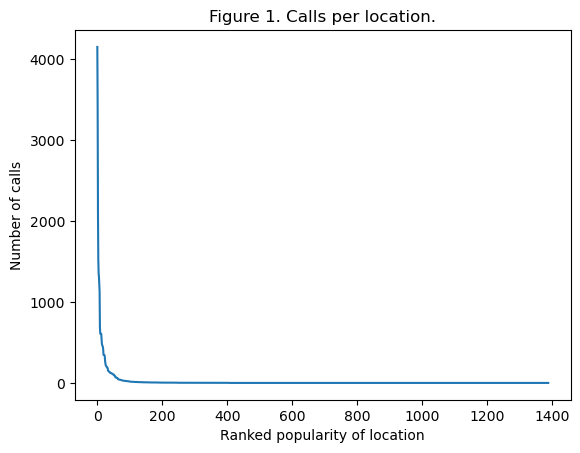

In [16]:
calls_counts_df = pd.DataFrame(calls_counts).reset_index().rename(columns = {
                                                                            "location_name": "count", 
                                                                            "index": "location"
                                                                            })
plt.plot(calls_counts_df.index, calls_counts_df['count'])
plt.title('Figure 1. Calls per location.')
plt.xlabel("Ranked popularity of location")
plt.ylabel("Number of calls")
plt.savefig("calls_popularity/per_location.png",
            dpi = 300,
            facecolor = "white",
            bbox_inches = "tight")
plt.show()

What percentage of call locations are only mentioned once?

In [17]:
len(calls_counts_df.loc[calls_counts_df["count"] == 1].index) / len(calls_counts_df.index)

0.707492795389049

What percentage of geocoded call locations are only mentioned once?

In [18]:
len(call_locations_df.loc[call_locations_df["lat"].notna()].index) / len(call_locations_df)

0.9095643649286196

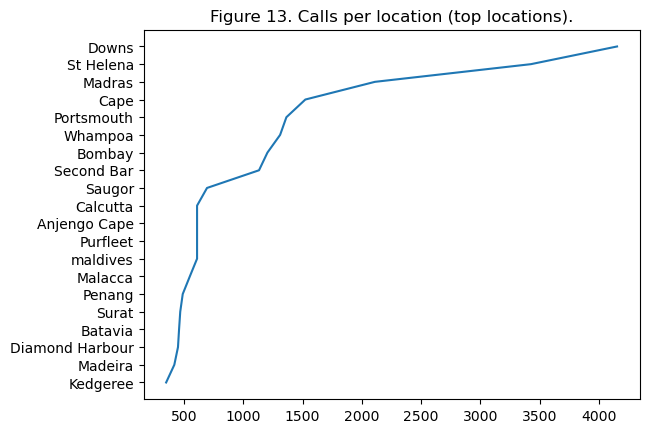

In [19]:
top_calls_counts_df = pd.DataFrame(top_calls).reset_index().rename(columns = {
                                                                            "location_name": "count", 
                                                                            "index": "location"
                                                                            })
plt.plot(top_calls_counts_df['count'], top_calls_counts_df['location'])
plt.gca().invert_yaxis()
plt.title("Figure 13. Calls per location (top locations).")
plt.savefig("calls_popularity/top_locations.png",
            dpi = 300,
            facecolor = "white",
            bbox_inches = "tight")
plt.show()

## Let's map the popularities of ports of call.

In [20]:
call_id_counts = call_locations_df["location_id"].value_counts()
call_id_counts_df = pd.DataFrame(call_id_counts).reset_index().rename(columns = {
                                                                            "location_id": "count", 
                                                                            "index": "location_id"
                                                                            })
call_id_locations_df = pd.merge(call_id_counts_df, locations_df,
                            how = "left",
                            on = "location_id")
call_id_locations_df = call_id_locations_df.loc[call_id_locations_df["lat"].notna()]
call_id_locations_df.head()

,location_id,count,location,category,lat,lon,region
0,l1,4154,Downs,calls,51.11080,1.29230,british_isles
1,l5,3427,St Helena,calls,-15.58000,-5.42000,atlantic
2,l4,2110,Madras,calls,13.45700,80.16300,madras_presidency
3,l11,1523,Cape,calls,-34.21290,18.28320,atlantic
4,l18,1363,Portsmouth,calls,50.79899,-1.09125,british_isles


In [21]:
call_id_locations_df.to_csv("calls_popularity/call_id_locations.csv", sep = ";", encoding = "utf8")

Filter that per century

In [22]:
def century_filter(start, end, name):
    call_locations_filter_df = call_locations_df.loc[(call_locations_df["year"] > start) & (call_locations_df["year"] < end)]
    call_id_counts_filter = call_locations_filter_df["location_id"].value_counts()
    call_id_counts_filter_df = pd.DataFrame(call_id_counts_filter).reset_index().rename(columns = {
                                                                                "location_id": "count", 
                                                                                "index": "location_id"
                                                                                })
    call_id_locations_filter_df = pd.merge(call_id_counts_filter_df, locations_df,
                                how = "left",
                                on = "location_id")
    call_id_locations_filter_df = call_id_locations_filter_df.loc[call_id_locations_filter_df["lat"].notna()]
    call_id_locations_filter_df.to_csv("calls_popularity/call_id_locations_" + name + ".csv", sep = ";", encoding = "utf8")
century_filter(1600, 1701, "sixteen")
century_filter(1700, 1801, "seventeen")
century_filter(1800, 1901, "eighteen")

## How did call regions change over time?

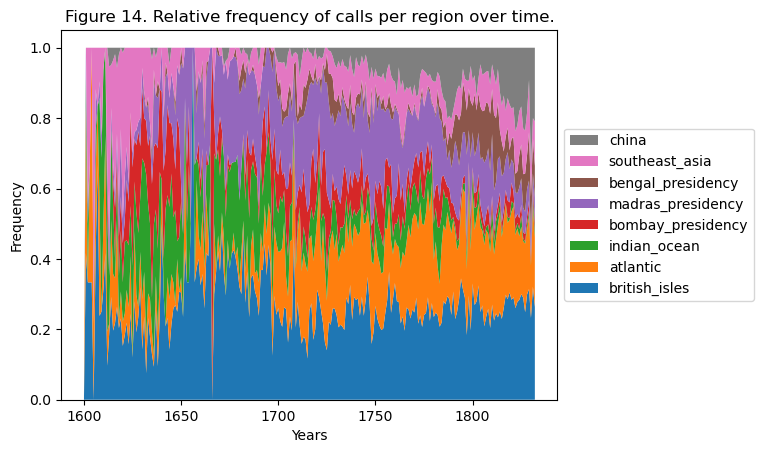

In [23]:
top_call_regions_df = call_locations_df.loc[call_locations_df["region"].notna()]
regions = top_call_regions_df["region"].unique().tolist()
top_call_regions_df = top_call_regions_df[["year", "region"]]
top_call_regions_dict = {}
for year in range(1600, 1833):
    region_mentions = top_call_regions_df.loc[top_call_regions_df["year"] == year]["region"].tolist()
    top_call_regions_dict[year] = {}
    if region_mentions:
        for region in regions:
            top_call_regions_dict[year][region] = (region_mentions.count(region) / len(region_mentions))
    else:
        for region in regions:
            top_call_regions_dict[year][region] = 0
top_call_regions_df = pd.DataFrame(top_call_regions_dict)
top_call_regions_df = top_call_regions_df.reindex(["british_isles", "atlantic", "indian_ocean", 
                                                   "bombay_presidency", "madras_presidency", "bengal_presidency",
                                                   "southeast_asia", "china"])
years = top_call_regions_df.columns
regions = top_call_regions_df.index
stack_data = top_call_regions_df.values.tolist()
plt.stackplot(years, stack_data, labels = regions)
plt.xlabel("Years")
plt.ylabel("Frequency")
plt.title("Figure 14. Relative frequency of calls per region over time.")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig("calls_popularity/regions_over_time.png",
            dpi = 300,
            facecolor = "white",
            bbox_inches = "tight")
plt.show()

## Comoros, Canary, Cape Verde

Filter to Comoros area

In [24]:
comoros_df = call_locations_df.loc[(call_locations_df["lat"] > -15) & (call_locations_df["lat"] < -10) & (call_locations_df["lon"] > 42) & (call_locations_df["lon"] < 46)]

How many calls were there in this area?

In [25]:
len(comoros_df.index)

384

At what ports were those?

In [26]:
comoros_df.value_counts("location_name")

location_name
Johanna    344
Moheli      38
Comoros      2
dtype: int64

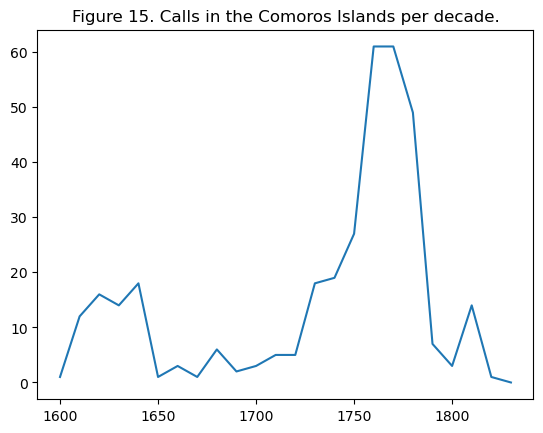

In [27]:
def get_decade_call_counts(region_df):
    region_dict = {}
    for decade in range(160, 184):
        decade_full = decade * 10
        region_dict[decade_full] = len(region_df.loc[region_df["year"] == int(str(decade + 1) + "0")].index)
        for year in range(1, 9):
            region_dict[decade_full] += len(region_df.loc[region_df["year"] == int(str(decade) + str(year))].index)
    region_counts_df = pd.DataFrame.from_dict(region_dict, orient = "index")
    region_counts_df = region_counts_df.reset_index().rename(columns = {"index": "year", 0: "count"})
    return region_counts_df
comoros_counts_df = get_decade_call_counts(comoros_df)
plt.plot(comoros_counts_df["year"], comoros_counts_df['count'])
plt.title('Figure 15. Calls in the Comoros Islands per decade.')
plt.savefig("calls_popularity/comoros_per_decade.png",
            dpi = 300,
            facecolor = "white",
            bbox_inches = "tight")
plt.show()

The same for Canaries and Cape Verde

In [28]:
canaries_df = call_locations_df.loc[(call_locations_df["lat"] > 27) & (call_locations_df["lat"] < 33) & (call_locations_df["lon"] > -20) & (call_locations_df["lon"] < -13)]
canaries_counts_df = get_decade_call_counts(canaries_df)
cape_verde_df = call_locations_df.loc[(call_locations_df["lat"] > 13) & (call_locations_df["lat"] < 18) & (call_locations_df["lon"] > -26) & (call_locations_df["lon"] < -20)]
cape_verde_counts_df = get_decade_call_counts(cape_verde_df)

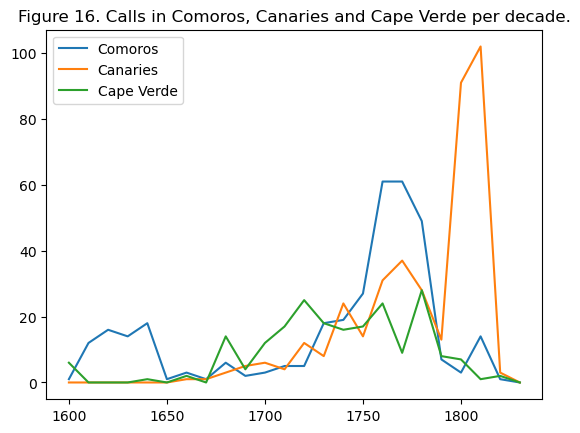

In [29]:
plt.plot(comoros_counts_df["year"], comoros_counts_df['count'], label = "Comoros")
plt.plot(canaries_counts_df["year"], canaries_counts_df['count'], label = "Canaries")
plt.plot(cape_verde_counts_df["year"], cape_verde_counts_df['count'], label = "Cape Verde")
plt.title('Figure 16. Calls in Comoros, Canaries and Cape Verde per decade.')
plt.legend()
plt.savefig("calls_popularity/three_cs.png",
            dpi = 300,
            facecolor = "white",
            bbox_inches = "tight")
plt.show()

## Bengal

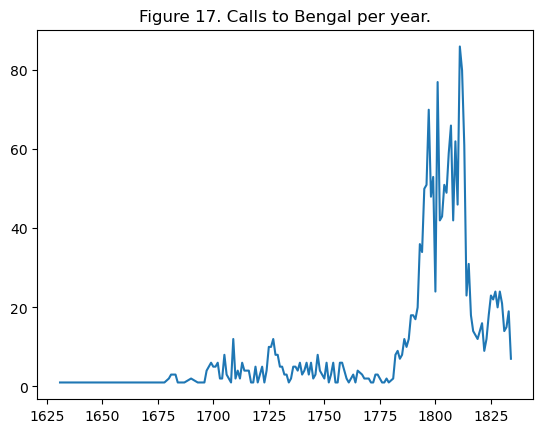

In [30]:
bengal_df = call_locations_df.loc[call_locations_df["region"] == "bengal_presidency"]
bengal_counts = bengal_df.groupby("year").size()
plt.plot(bengal_counts.index, bengal_counts.values)
plt.title("Figure 17. Calls to Bengal per year.")
plt.savefig("calls_popularity/bengal_per_year.png",
            dpi = 300,
            facecolor = "white",
            bbox_inches = "tight")
plt.show()

In [31]:
bengal_counts_df = pd.DataFrame(bengal_counts)
bengal_counts_df = bengal_counts_df.reset_index().rename(columns = {0: "count"})
bengal_counts_df.loc[bengal_counts_df["year"] > 1770][:10]

,year,count
92,1771,1
93,1772,1
94,1773,3
95,1774,3
96,1776,1
97,1777,1
98,1778,2
99,1779,1
100,1781,2
101,1782,8


## China

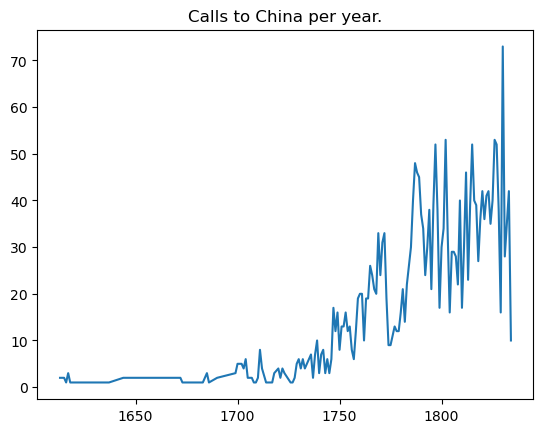

In [32]:
china_df = call_locations_df.loc[call_locations_df["region"] == "china"]
china_counts_df = china_df.groupby("year").size()
plt.plot(china_counts_df.index, china_counts_df.values)
plt.title("Calls to China per year.")
#plt.savefig("calls_popularity/china_per_year.png",
#            dpi = 300,
#            facecolor = "white",
#            bbox_inches = "tight")
plt.show()

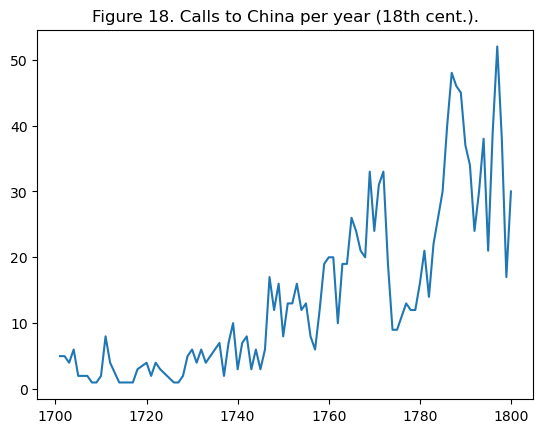

In [33]:
china_detail_df = china_df.loc[(china_df["year"] > 1700) & (china_df["year"] < 1801)]
china_detail_counts_df = china_detail_df.groupby("year").size()
plt.plot(china_detail_counts_df.index, china_detail_counts_df.values)
plt.title("Figure 18. Calls to China per year (18th cent.).")
plt.savefig("calls_popularity/china_per_year.png",
            dpi = 300,
            facecolor = "white",
            bbox_inches = "tight")
plt.show()

In [34]:
china_call_percentage_df = top_call_regions_df.transpose().loc[1701:1800]
china_call_percentage_df = china_call_percentage_df.drop(columns = ["british_isles", "atlantic"])
china_call_percentage_df.idxmax(axis = 1)[50:]

1751    madras_presidency
1752    madras_presidency
1753    madras_presidency
1754    madras_presidency
1755    bombay_presidency
1756    madras_presidency
1757    madras_presidency
1758    madras_presidency
1759    madras_presidency
1760    madras_presidency
1761    madras_presidency
1762    bombay_presidency
1763    madras_presidency
1764       southeast_asia
1765    madras_presidency
1766    madras_presidency
1767    madras_presidency
1768    madras_presidency
1769    madras_presidency
1770    madras_presidency
1771                china
1772    madras_presidency
1773    madras_presidency
1774    madras_presidency
1775    madras_presidency
1776    madras_presidency
1777    madras_presidency
1778    madras_presidency
1779    madras_presidency
1780    madras_presidency
1781    madras_presidency
1782    madras_presidency
1783    madras_presidency
1784    madras_presidency
1785                china
1786                china
1787                china
1788                china
1789        

## Connections

Filter only to completely geocoded voyages

In [35]:
voyage_list = voyages_df["voyage_id"].tolist()
geocoded_voyages_list = []
def contains_nan(input_list):
    return any(math.isnan(x) for x in input_list)
for voyage_id in voyage_list:
    df = call_locations_df.loc[call_locations_df["voyage_id"] == voyage_id]
    geocoded_list = df["lat"].tolist()
    if len(geocoded_list) > 1 and not contains_nan(geocoded_list):
        geocoded_voyages_list.append(voyage_id)

Export geocoded locations

In [36]:
geocoded_df = locations_df.loc[locations_df["category"] == "calls"]
geocoded_df = geocoded_df.loc[geocoded_df["lat"].notna()]
with open("./calls_connections/locations.csv", "w") as file:
    file.write("id;name;lat;lon\n")
    for index, row in geocoded_df.iterrows():
        location_id = row["location_id"]
        location_label = row["location"]
        lat = row["lat"]
        lon = row["lon"]
        file.write(str(location_id) + ";" + str(location_label) + ";" + str(lat) + ";" + str(lon) + "\n")

Export connections between call locations

In [37]:
geocoded_calls_list = list(set(call_locations_df.loc[call_locations_df["lat"].notna()]["location_id"].tolist()))
connections_dict = {}
for voyage_id in geocoded_voyages_list:
    df = calls_df.loc[calls_df["voyage_id"] == voyage_id]
    years_list = df["year"].tolist()
    calls_list = df["location"].tolist()
    for connection in range(len(calls_list) - 1):
        year = years_list[connection]
        if year in range(1600, 1850):
            first_call = calls_list[connection]
            second_call = calls_list[connection + 1]
            if year not in connections_dict.keys():
                connections_dict[year] = {}
            if first_call not in connections_dict[year].keys():
                connections_dict[year][first_call] = {}
            if second_call not in connections_dict[year][first_call].keys():
                connections_dict[year][first_call][second_call] = 0
            connections_dict[year][first_call][second_call] += 1
with open("./calls_connections/flows.csv", "w") as file:
    file.write("origin;dest;count;time\n")
    for year in connections_dict.keys():
        for first_call in connections_dict[year].keys():
            for second_call in connections_dict[year][first_call].keys():
                if not connections_dict[year][first_call][second_call] == 0:
                    if first_call == "nan" or second_call == "nan":
                        print(first_call, second_call)
                    file.write(str(first_call) + ";" + str(second_call) + ";" + str(connections_dict[year][first_call][second_call]) + ";" + str(year) + "\n")

In [38]:
flows_df = pd.read_csv("./calls_connections/flows.csv", sep = ";")

How many connections do we have?

In [39]:
flows_df["count"].sum()

12918

In [40]:
flows_df.head()

,origin,dest,count,time
0,l1,l2,1,1819
1,l1,l5,2,1819
2,l1,l4,1,1819
3,l1,l12,5,1819
4,l1,l8,1,1819


In [41]:
flow_locations_origin_df = pd.merge(flows_df, locations_df,
                            how = "left",
                            left_on = "origin",
                            right_on = "location_id")
flow_locations_origin_df = flow_locations_origin_df.rename(columns = {"location_id": "origin_id"})
flow_locations_df = pd.merge(flow_locations_origin_df, locations_df,
                            how = "left",
                            left_on = "dest",
                            right_on = "location_id")
flow_locations_df = flow_locations_df.rename(columns = {"location_id": "dest_id"})
flow_locations_df.head()

,origin,dest,count,time,origin_id,location_x,category_x,lat_x,lon_x,region_x,dest_id,location_y,category_y,lat_y,lon_y,region_y
0,l1,l2,1,1819,l1,Downs,calls,51.1108,1.2923,british_isles,l2,Bengal,calls,21.36230,88.09320,bengal_presidency
1,l1,l5,2,1819,l1,Downs,calls,51.1108,1.2923,british_isles,l5,St Helena,calls,-15.58000,-5.42000,atlantic
2,l1,l4,1,1819,l1,Downs,calls,51.1108,1.2923,british_isles,l4,Madras,calls,13.45700,80.16300,madras_presidency
3,l1,l12,5,1819,l1,Downs,calls,51.1108,1.2923,british_isles,l12,Bombay,calls,19.07283,72.88261,bombay_presidency
4,l1,l8,1,1819,l1,Downs,calls,51.1108,1.2923,british_isles,l8,Calcutta,calls,22.34030,88.22120,bengal_presidency


What were the most popular connections?

In [42]:
flow_locations_overall_df = flow_locations_df.groupby(['origin', 'dest'])['count'].sum().reset_index()
flow_locations_overall_origin_df = pd.merge(flow_locations_overall_df, locations_df,
                            how = "left",
                            left_on = "origin",
                            right_on = "location_id")
flow_locations_overall_origin_df = flow_locations_overall_origin_df.rename(columns = {"location_id": "origin_id"})
flow_locations_overall_df = pd.merge(flow_locations_overall_origin_df, locations_df,
                            how = "left",
                            left_on = "dest",
                            right_on = "location_id")
flow_locations_overall_df = flow_locations_overall_df.rename(columns = {"location_x": "origin_name", "location_y": "dest_name"})
flow_locations_overall_df.sort_values(by = "count", ascending = False)[:10][["origin_name", "dest_name", "count"]]

,origin_name,dest_name,count
876,St Helena,Downs,1167
280,Whampoa,Second Bar,825
431,Second Bar,St Helena,608
137,Cape,St Helena,375
879,St Helena,Long Reach,240
308,Malacca,Whampoa,227
1006,Diamond Harbour,Saugor,200
388,Portsmouth,Madras,152
782,Madras,Diamond Harbour,145
779,Madras,St Helena,145


In [43]:
ships_df.loc[ships_df["ship_id"] == "s22"]

,ship_id,name,raw,tons,tons_min,tons_max,guns,guns_min,guns_max,crew,crew_min,crew_max,type,built_by,built_year,built_at
21,s22,AFRICAN,"['240 tons', 'BL: Lansdowne Ms 213 Journal on ...",240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
voyage_length_df = pd.DataFrame(calls_df.groupby("voyage_id").size())
voyage_length_df = voyage_length_df.reset_index().rename(columns = {0: "count"})
short_voyages_list = voyage_length_df.loc[voyage_length_df["count"] == 3]["voyage_id"].tolist()
calls_df.loc[(calls_df["voyage_id"].isin(short_voyages_list)) & (calls_df["year"] < 1700)][:20]

,ship_id,voyage_id,call_id,raw,year,month,day,location,special
298,s19,s19v1,s19v1c1,Downs,1619,NaN,NaN,l1,False
299,s19,s19v1,s19v1c2,12 Aug 1637 Masulipatam,1637,8.0,12.0,l91,False
300,s19,s19v1,s19v1c3,7 Jan 1639 Plymouth,1639,1.0,7.0,l85,False
311,s22,s22v3,s22v3c1,Downs 23 Mar 1665,1665,3.0,23.0,l1,False
312,s22,s22v3,s22v3c2,3 Sep Surat 10 Sep 1666,1666,9.0,10.0,l33,False
313,s22,s22v3,s22v3c3,Mar 1667 Downs,1667,3.0,NaN,l1,False
519,s30,s30v2,s30v2c1,Downs Apr 1648,1648,4.0,NaN,l1,False
520,s30,s30v2,s30v2c2,27 Sep Surat 1 Feb 1649,1649,2.0,1.0,l33,False
521,s30,s30v2,s30v2c3,Downs,1649,NaN,NaN,l1,False
522,s30,s30v3,s30v3c1,Downs 20 Mar 1650,1650,3.0,20.0,l1,False
